# Quora Insinscere question detection
This is a notebook to explore the challenge of deecting if a given question on quora is sinscere or not. More details can be found at - 
https://www.kaggle.com/c/quora-insincere-questions-classification/data

Rough outline of the approaches I plan to exxpreiment with - 

- Use linear models on sentence embeddings, exploring various approaches to get sentence embeddings from word embeddings
- Use NN on sentence embeddings
- Use LSTM on word embeddings


In [80]:
import pandas as pd
import numpy as np
import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv" , index_col = "qid")


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1306122 entries, 00002165364db923c7e6 to ffffed09fedb5088744a
Data columns (total 2 columns):
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(1)
memory usage: 29.9+ MB


In [4]:
train.head()


,question_text,target
qid,,
00002165364db923c7e6,How did Quebec nationalists see their province...,0
000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
train.shape[0]

1306122

In [6]:
(train['target'].value_counts() / train.shape[0])

0    0.93813
1    0.06187
Name: target, dtype: float64

Data set is imbalanced. We have aroound 1.3 mn questions which is quite large. There are no missing values in the target variable.

In [7]:

train_df, test_df = train_test_split(train , train_size = 0.7, random_state = 1)

test_df.shape

/Users/dhruv/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(391837, 2)

## Using sentence embeddings



In [8]:
words_to_index, index_to_words, word_to_vec_map = utils.read_glove_vecs('data/glove.6B.50D.txt')
embed_size = word_to_vec_map['potatoes'].shape[0]

In [9]:
embed_feature_matrix = np.zeros((train.shape[0] , embed_size))

for i in range(train.shape[0]):
    avg = np.zeros(embed_size)
    sentence = train['question_text'].iloc[i]
    for w in sentence.split():
        avg = (avg + word_to_vec_map[w.lower()]) if w in words_to_index.keys() else avg
    avg = avg/len(sentence.split())
    embed_feature_matrix[i,:] = avg

In [10]:
embed_feature_matrix[1,:]

array([ 0.30652914, -0.04615969,  0.03461759, -0.32862106,  0.32389972,
        0.11798259, -0.31097   , -0.17440473, -0.18743   ,  0.05849787,
        0.02323312,  0.25310656, -0.04408219, -0.06636275,  0.39459031,
        0.41205156,  0.19186312, -0.04145169,  0.17174231, -0.51833125,
       -0.02230881,  0.20463238,  0.230813  ,  0.08086213,  0.27062426,
       -1.4915    , -0.31363788, -0.16113384,  0.28794744, -0.42191206,
        2.8637    ,  0.37205625, -0.5678375 , -0.36670375,  0.00532304,
       -0.16805575,  0.08249931, -0.00493012, -0.05710663, -0.15098275,
       -0.27497237,  0.01004969,  0.20942125,  0.27642663,  0.13349706,
        0.03729038, -0.22709063,  0.06868144, -0.03569675,  0.20406713])

In [11]:
logistic_model = LogisticRegression(penalty= "l2" , C = 1)
logistic_model.fit(embed_feature_matrix , train['target'])

/Users/dhruv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
test_pred_losgistic_model = logistic_model.predict(embed_feature_matrix)

accuracy_score(train['target'] , test_pred_losgistic_model )
f1_score(train['target'] , test_pred_losgistic_model)

0.11915441570984013

Pretty bad performance for logistic regression with sentence embeddings. This was to be expected since insinscerity is a very subtle train that is hard to pick up on without word equence information - whicis lost while averaging word embeddings to get sentence embeddings. We need to have a model that catures the context better - something like an RNN.

## RNN with word embeddings

In [13]:

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform


Using TensorFlow backend.


In [14]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len , emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [15]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)

    X_indices = np.zeros((m ,max_len ))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            if w in word_to_index.keys():
            # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
                j = j+1
            
    ### END CODE HERE ###
    
    return X_indices

In [115]:
def LSTM_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape , dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_ indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(256,return_sequences=False )(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    out = Dense(16, activation="tanh")(X)
    out = Dense(1, activation="softmax")(out)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices , outputs = out)
    
    ### END CODE HERE ###
    
    return model

In [95]:
maxLen = max([len(x.split()) for x in  list(train_df['question_text'])])


In [116]:

model = LSTM_model((maxLen,), word_to_vec_map, words_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 134)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 134, 50)           20000050  
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 20,318,547
Trainable params: 318,497
Non-trainable params: 20,000,050
__________________________________________________________

In [117]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return y_pred


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])

In [105]:
X_train_indices = sentences_to_indices(np.asarray(train_df['question_text']), words_to_index, maxLen)
Y_train = np.asarray(train_df['target'])


In [92]:
np.sum(Y_train)

56465

In [118]:
history = model.fit(x= X_train_indices[:20480, ], y= Y_train[:20480], batch_size=512, epochs=2, verbose=1, callbacks=None, validation_split=0.2)



Train on 16384 samples, validate on 4096 samples
Epoch 1/2
11264/16384 [===================>..........] - ETA: 35s - loss: 15.0536 - acc: 0.0558 - f1_m: 1.0000

KeyboardInterrupt: 

In [107]:

y_pred = model.predict(X_train_indices[:10240, ])
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())



dict_keys(['val_loss', 'val_acc', 'val_f1_m', 'loss', 'acc', 'f1_m'])


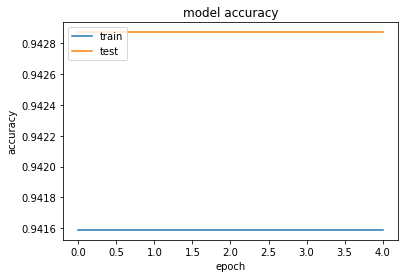

In [108]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [78]:
y_pred

array([[0.05566478],
       [0.05566487],
       [0.05566487],
       ...,
       [0.05566478],
       [0.05566478],
       [0.05566478]], dtype=float32)

In [79]:
pd.DataFrame(y_pred).describe()

,0
count,1.024000e+04
mean,5.566408e-02
std,6.827962e-07
min,5.566293e-02
25%,5.566478e-02
50%,5.566478e-02
75%,5.566478e-02
max,5.566496e-02
